In [1]:
import pandas as pd
import numpy as np

In [47]:
events = pd.read_csv('box_data/hdr_boxes/events.txt', sep=' ', header=None, names = ['t', 'x', 'y', 'p'])
width = events.x.max() + 1
height = events.y.max() + 1
print(width, height)
events.head()

240 180


,t,x,y,p
0,0.000000,82,34,0
1,0.000007,202,175,1
2,0.000008,111,34,0
3,0.000011,168,79,0
4,0.000016,220,146,1


In [48]:
imgs = pd.read_csv('box_data/hdr_boxes/images.txt', sep=' ', header=None, names = ['t', 'file_name'])
imgs.head()

,t,file_name
0,0.020235,images/frame_00000000.png
1,0.063301,images/frame_00000001.png
2,0.106366,images/frame_00000002.png
3,0.149431,images/frame_00000003.png
4,0.192497,images/frame_00000004.png


In [49]:
gt = pd.read_csv('box_data/hdr_boxes/groundtruth.txt', sep=' ', header=None, names = ['t', 'px', 'py', 'pz', 'qx', 'qy', 'qz', 'qw'])
gt.head()

,t,px,py,pz,qx,qy,qz,qw
0,0.037317,0.546509,1.317912,1.065833,-0.056709,0.845480,-0.530636,0.019303
1,0.042316,0.546408,1.317874,1.065777,-0.057004,0.845073,-0.531263,0.019011
2,0.047317,0.546362,1.317940,1.065950,-0.057182,0.845414,-0.530695,0.019186
3,0.052317,0.546348,1.317924,1.066047,-0.057022,0.845301,-0.530888,0.019307
4,0.057317,0.546249,1.317981,1.065999,-0.057371,0.845140,-0.531109,0.019222


In [50]:
# create 3x3 roation matrix from quaternion
def quat2rot(q):
    qx, qy, qz, qw = q[4], q[5], q[6], q[7]
    norm = (qx**2 + qy**2 + qz**2 + qw**2)**0.5
    qx, qy, qz, qw = qx/norm, qy/norm, qz/norm, qw/norm
    R = np.array([[1-2*qy**2-2*qz**2, 2*qx*qy-2*qz*qw, 2*qx*qz+2*qy*qw],
                    [2*qx*qy+2*qz*qw, 1-2*qx**2-2*qz**2, 2*qy*qz-2*qx*qw],
                    [2*qx*qz-2*qy*qw, 2*qy*qz+2*qx*qw, 1-2*qx**2-2*qy**2]])
    return R

#create 4x4 orientation matrix from quaternion
def quat2mat(q):
    px, py, pz = q[1], q[2], q[3]
    R = quat2rot(q)
    T = np.eye(4)
    T[:3,:3] = R
    T[:3,3] = np.array([px, py, pz])
    return T

gt['orientation_matrix'] = gt.apply(quat2mat, axis=1)
gt.head()

,t,px,py,pz,qx,qy,qz,qw,orientation_matrix
0,0.037317,0.546509,1.317912,1.065833,-0.056709,0.845480,-0.530636,0.019303,"[[-0.9928230063093074, -0.07540661415559632, 0..."
1,0.042316,0.546408,1.317874,1.065777,-0.057004,0.845073,-0.531263,0.019011,"[[-0.9927781348021419, -0.07614579355669726, 0..."
2,0.047317,0.546362,1.317940,1.065950,-0.057182,0.845414,-0.530695,0.019186,"[[-0.9927242097360401, -0.07632124458591788, 0..."
3,0.052317,0.546348,1.317924,1.066047,-0.057022,0.845301,-0.530888,0.019307,"[[-0.9927514716897928, -0.0759009668102815, 0...."
4,0.057317,0.546249,1.317981,1.065999,-0.057371,0.845140,-0.531109,0.019222,"[[-0.9926782484589247, -0.07655391133939506, 0..."


In [51]:
#build dataset
seed = 42
np.random.seed(seed)
interval = np.random.uniform(2, 4)
print(f"The size of interval is {interval} seconds")
packets = []

start_time_interval = 0
end_time_interval = interval
count = 1

while start_time_interval < imgs.t.max():
    interval_imgs = imgs[(imgs.t >= start_time_interval) & (imgs.t < end_time_interval)]
    interval_imgs['t2'] = interval_imgs['t'].shift(-1)
    interval_imgs['file_name_2'] = interval_imgs['file_name'].shift(-1)

    closest_pose = []
    for t in interval_imgs['t']:
        closest_index = np.abs(gt.t - t).argmin()
        closest_pose.append(gt.iloc[closest_index]['orientation_matrix'])
    interval_imgs['t_pose'] = closest_pose
    interval_imgs['t2_pose'] = interval_imgs['t_pose'].shift(-1)
    #remove the last line of the data frame since it contains NaNs
    interval_imgs = interval_imgs[:-1]
    packets.append(interval_imgs)

    print(f"Packet {count} is composed of {len(interval_imgs)} event windows")
    start_time_interval = end_time_interval
    end_time_interval += interval
    count += 1

The size of interval is 2.749080237694725 seconds
Packet 1 is composed of 63 event windows
Packet 2 is composed of 63 event windows
Packet 3 is composed of 63 event windows
Packet 4 is composed of 62 event windows
Packet 5 is composed of 63 event windows
Packet 6 is composed of 63 event windows
Packet 7 is composed of 63 event windows
Packet 8 is composed of 63 event windows
Packet 9 is composed of 63 event windows
Packet 10 is composed of 62 event windows
Packet 11 is composed of 63 event windows
Packet 12 is composed of 63 event windows
Packet 13 is composed of 63 event windows
Packet 14 is composed of 63 event windows
Packet 15 is composed of 63 event windows
Packet 16 is composed of 62 event windows
Packet 17 is composed of 63 event windows
Packet 18 is composed of 63 event windows
Packet 19 is composed of 63 event windows
Packet 20 is composed of 63 event windows


/var/folders/ct/ks3946251nx_c841_wpsn0v40000gn/T/ipykernel_72774/1654845843.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_imgs['t2'] = interval_imgs['t'].shift(-1)
/var/folders/ct/ks3946251nx_c841_wpsn0v40000gn/T/ipykernel_72774/1654845843.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_imgs['file_name_2'] = interval_imgs['file_name'].shift(-1)
/var/folders/ct/ks3946251nx_c841_wpsn0v40000gn/T/ipykernel_72774/1654845843.py:21: SettingWithCopyWarning: 
A value is trying to be set

Packet 21 is composed of 63 event windows
Packet 22 is composed of 46 event windows


/var/folders/ct/ks3946251nx_c841_wpsn0v40000gn/T/ipykernel_72774/1654845843.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_imgs['t_pose'] = closest_pose
/var/folders/ct/ks3946251nx_c841_wpsn0v40000gn/T/ipykernel_72774/1654845843.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_imgs['t2_pose'] = interval_imgs['t_pose'].shift(-1)
/var/folders/ct/ks3946251nx_c841_wpsn0v40000gn/T/ipykernel_72774/1654845843.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [52]:
sample = packets[0].iloc[1]
sample

t                                                       0.063301
file_name                              images/frame_00000001.png
t2                                                      0.106366
file_name_2                            images/frame_00000002.png
t_pose         [[-0.9927625111632475, -0.07601831183786943, 0...
t2_pose        [[-0.9927096918568961, -0.0752058634144892, 0....
Name: 1, dtype: object

In [54]:
# events.loc[events['t'] >= sample['t'] & events.loc[events['t']] < sample['t2']]
# #speed up the previouis line of code by using the following code
# #events.loc[(events['t'] >= sample['t']) & (events['t'] < sample['t2'])]
r_events = events.loc[(events['t'] >= sample['t']) & (events['t'] < sample['t2'])]

dataset_windows = []
pose_pairs = []
events_list = []
image_pairs = []

for i in range(len(packets)):
    p = packets[i]
    windows = []
    for wi in range(len(p)):
        #get one window description
        wd = p.iloc[wi]
        data = {}
        data['t1'] = wd['t']
        data['t2'] = wd['t2']
        data['img1'] = wd['file_name']
        data['img2'] = wd['file_name_2']
        data['p1'] = wd['t_pose']
        data['p2'] = wd['t2_pose']
        data['events'] = events.loc[(events['t'] >= wd['t']) & (events['t'] < wd['t2'])].values
        events_list.append(data['events'])
        pose_pairs.append([data['p1'], data['p2']])
        windows.append(data)
        image_pairs.append([data['img1'], data['img2']])
    dataset_windows.append(windows)

In [64]:
indexes = list(range(len(pose_pairs)))
print(indexes[:10])
np.random.shuffle(indexes)
print(indexes[:10])

i_train, i_val, i_test = np.split(indexes, [int(.7*len(indexes)), int(.85*len(indexes))])
print(len(i_train), len(i_val), len(i_test))
print(len(i_train) + len(i_val) + len(i_test))
print(len(indexes))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1330, 567, 1046, 602, 1275, 1202, 103, 538, 509, 747]
956 205 205
1366
1366


In [65]:
# Read calibration matrix from file
with open('box_data/hdr_boxes/calib.txt', 'r') as f:
    calib = [float(x) for x in f.readline().split()]

# Extract focal length
fx, fy = calib[:2]
focal_length = np.mean([fx, fy])  # Use mean of fx and fy as focal length

print('Focal length:', focal_length)

Focal length: 198.960593506


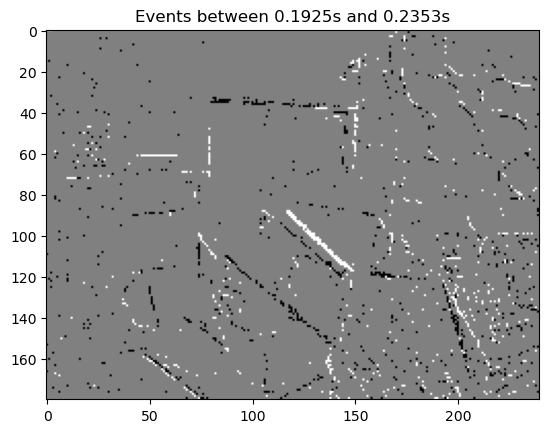

In [45]:
import matplotlib.pyplot as plt

def visualize_events(events, width, height, time_window=0.1):
    """
    Visualize events from an event camera.
    
    Args:
        events (numpy array): A numpy array of events, shape (N, 4), where N is the number of events and
                              each event is represented as (timestamp, x, y, polarity).
        width (int): Width of the event camera sensor (number of pixels).
        height (int): Height of the event camera sensor (number of pixels).
        time_window (float): Time window to accumulate events for visualization, in seconds.
    """
    start_time = events[0, 0]
    end_time = events[-1, 0]

    current_time = start_time
    event_index = 0

    while current_time < end_time:
        event_image = np.zeros((height, width), dtype=np.int8)

        while event_index < len(events) and events[event_index, 0] < current_time + time_window:
            _, x, y, polarity = events[event_index]
            event_image[int(y), int(x)] = 1 if polarity > 0 else -1
            event_index += 1

        plt.imshow(event_image, cmap='gray', vmin=-1, vmax=1)
        plt.title(f'Events between {start_time:.4f}s and {end_time:.4f}s')
        plt.pause(0.1)

        current_time += time_window


visualize_events(dataset[0][4]['events'], width, height)
